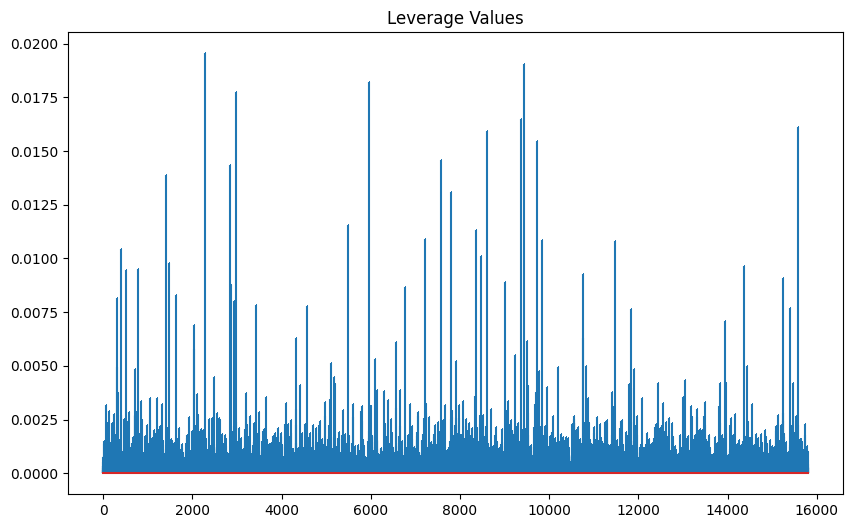

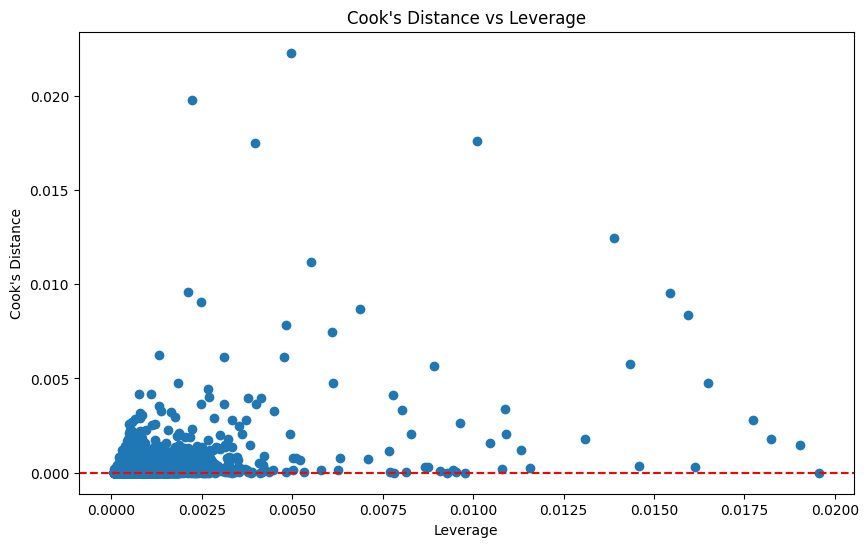

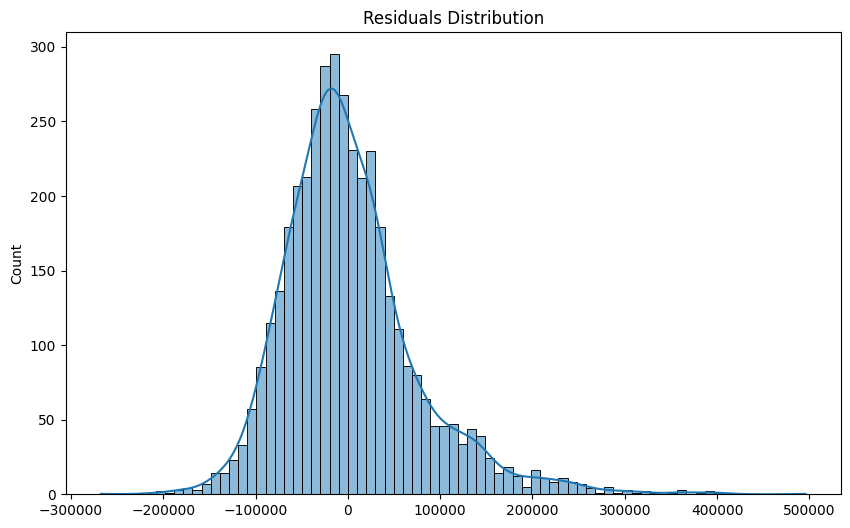

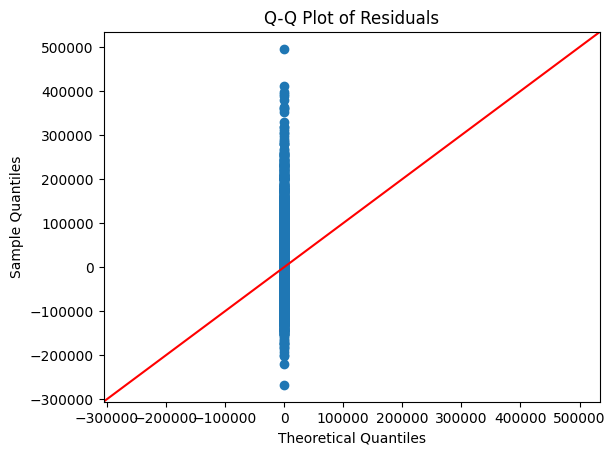

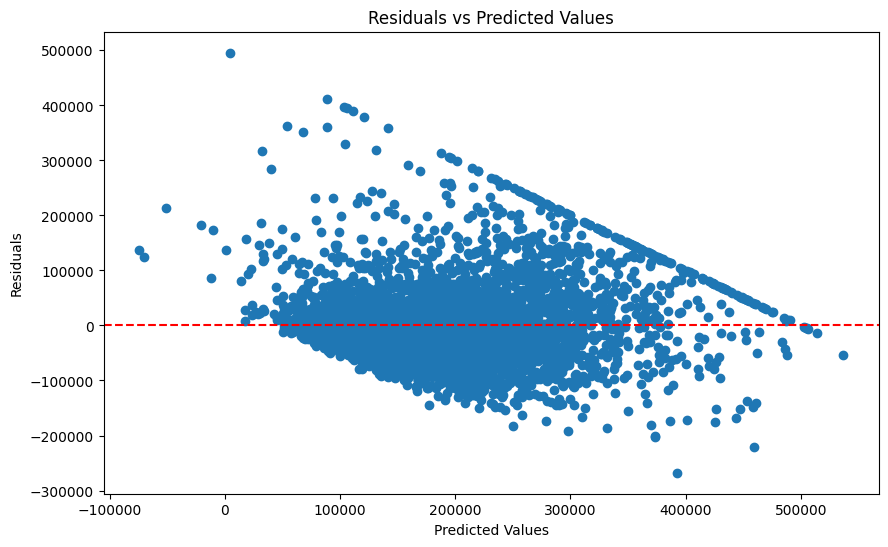

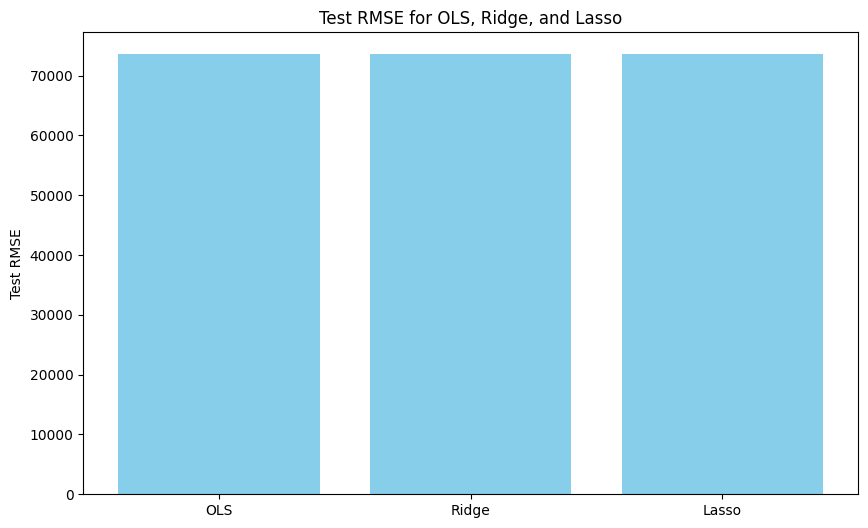

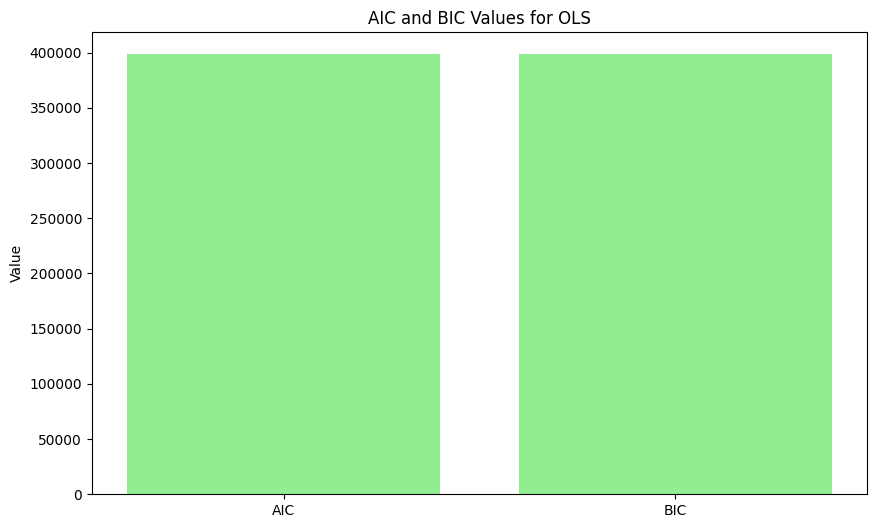



--- Model Selection Summary ---
Selected Model: OLS
Best Test RMSE: 73559.74
AIC: 398486.02, BIC: 398539.70, Adjusted R2: 0.57
Shapiro Test P-Value: 0.00 (Normality)
Breusch-Pagan P-Value: 0.00 (Homoscedasticity)
F-Test for Nested Models: F-Statistic = 4583.35, P-Value = 0.00


{'selected_model': 'OLS',
 'cv_rmse': 72752.68370764771,
 'test_rmse': 73559.73724380572,
 'aic': 398486.024365993,
 'bic': 398539.69695014984,
 'adjusted_r2': 0.5664733352601723,
 'shapiro_test_pval': 1.9191305438346115e-38,
 'breusch_pagan_pval': 5.2116115591177924e-23,
 'f_test': (4583.345264604525, 0.0, 4.0)}

In [28]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'housing.csv'
data = pd.read_csv(file_path)

# Function to preprocess data, build models, and compare techniques
def linear_regression_pipeline(X, y):
    """

    End-to-end linear regression pipeline.
    This function wrap all components into one major function.
    It handles preprocessing, builds models, evaluates them, and provides results.

    Parameters:
        X (pd.DataFrame): Input features.
        y (pd.Series or np.array): Target variable.

    Returns:
        dict: A dictionary containing key results and metrics.

    """

    # Preprocessing
    # Handle missing values
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    # Detect and remove outliers using Z-score
    z_scores = np.abs((X_imputed - np.mean(X_imputed, axis=0)) / np.std(X_imputed, axis=0))
    outlier_indices = np.where(z_scores > 3)
    X_cleaned = np.delete(X_imputed, outlier_indices[0], axis=0)
    y_cleaned = np.delete(y, outlier_indices[0], axis=0)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cleaned)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cleaned, test_size=0.2, random_state=42)

    # OBJECTIVE 1: Compare Lasso, Ridge, and OLS Regression
    models = {
        "OLS": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso()
    }

    results = {}
    for name, model in models.items():
        if name in ["Ridge", "Lasso"]:
            param_grid = {"alpha": np.logspace(-3, 3, 10)}
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_squared_error")
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            best_model = model.fit(X_train, y_train)

        cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
        test_predictions = best_model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

        results[name] = {
            "model": best_model,
            "cv_rmse": np.sqrt(-cv_scores.mean()),
            "test_rmse": test_rmse
        }

    # OBJECTIVE 2: Outliers, Influential Points, and High Leverage
    # Fit an OLS model for diagnostics
    ols_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    influence = OLSInfluence(ols_model)

    # Residual diagnostics
    leverage = influence.hat_matrix_diag
    cooks_d = influence.cooks_distance[0]

    # Leverage and influence diagnostics
    plt.figure(figsize=(10, 6))
    plt.stem(np.arange(len(leverage)), leverage, markerfmt=",")
    plt.title("Leverage Values")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(leverage, cooks_d)
    plt.title("Cook's Distance vs Leverage")
    plt.xlabel("Leverage")
    plt.ylabel("Cook's Distance")
    plt.axhline(0, color='red', linestyle='--')
    plt.show()

    # OBJECTIVE 3: Model Selection Metrics (AIC, BIC, Mallow's Cp, Adjusted R2)
    aic = ols_model.aic
    bic = ols_model.bic
    adj_r2 = ols_model.rsquared_adj

    # OBJECTIVE 4: Diagnostics - Normality, Homoscedasticity, and Linearity
    residuals = y_test - results["OLS"]["model"].predict(X_test)

    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title("Residuals Distribution")
    plt.show()

    sm.qqplot(residuals, line='45')
    plt.title("Q-Q Plot of Residuals")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(results["OLS"]["model"].predict(X_test), residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs Predicted Values")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

    # Normality test
    shapiro_test = shapiro(residuals)

    # Breusch-Pagan test for homoscedasticity
    X_test_with_constant = sm.add_constant(X_test)
    _, pval, _, _ = het_breuschpagan(residuals, X_test_with_constant)

    # OBJECTIVE 5: Transformations
    transformer = PowerTransformer()
    y_transformed = transformer.fit_transform(y_cleaned.reshape(-1, 1)).flatten()

    # OBJECTIVE 6: Formal F-Test for Nested Models
    reduced_model = sm.OLS(y_train, sm.add_constant(X_train[:, :2])).fit()
    f_test = ols_model.compare_f_test(reduced_model)

    # Explanatory plots
    test_rmses = [results[model]["test_rmse"] for model in results]
    models_list = list(results.keys())
    plt.figure(figsize=(10, 6))
    plt.bar(models_list, test_rmses, color='skyblue')
    plt.title("Test RMSE for OLS, Ridge, and Lasso")
    plt.ylabel("Test RMSE")
    plt.show()

    # AIC and BIC comparison
    plt.figure(figsize=(10, 6))
    plt.bar(["AIC", "BIC"], [aic, bic], color='lightgreen')
    plt.title("AIC and BIC Values for OLS")
    plt.ylabel("Value")
    plt.show()

    # Generate Summary of Results for Explanatory Plots and Interpretation
    print("")
    print("")
    print("--- Model Selection Summary ---")
    print(f"Selected Model: {min(results, key=lambda k: results[k]['test_rmse'])}")
    print(f"Best Test RMSE: {min([results[model]['test_rmse'] for model in results]):.2f}")
    print(f"AIC: {aic:.2f}, BIC: {bic:.2f}, Adjusted R2: {adj_r2:.2f}")
    print(f"Shapiro Test P-Value: {shapiro_test.pvalue:.2f} (Normality)")
    print(f"Breusch-Pagan P-Value: {pval:.2f} (Homoscedasticity)")
    print(f"F-Test for Nested Models: F-Statistic = {f_test[0]:.2f}, P-Value = {f_test[1]:.2f}")

    # Return final results
    final_results = {
        "selected_model": min(results, key=lambda k: results[k]["test_rmse"]),
        "cv_rmse": results[min(results, key=lambda k: results[k]["test_rmse"])]["cv_rmse"],
        "test_rmse": results[min(results, key=lambda k: results[k]["test_rmse"])]["test_rmse"],
        "aic": aic,
        "bic": bic,
        "adjusted_r2": adj_r2,
        "shapiro_test_pval": shapiro_test.pvalue,
        "breusch_pagan_pval": pval,
        "f_test": f_test
    }

    return final_results

# Preprocessing the dataset
data_cleaned = data.drop(columns=["longitude", "latitude", "ocean_proximity"])
X = data_cleaned.drop(columns=["median_house_value"])
y = data_cleaned["median_house_value"].values

# Running the pipeline
pipeline_results = linear_regression_pipeline(X, y)
pipeline_results


In [ ]:
'''

DUC PHAM
MATH372 - FALL 2024
04 DEC 2024

FINAL PROJECT

Dataset: Kaggle - California Housing Prices
https://www.kaggle.com/datasets/camnugent/california-housing-prices


Explanatory Plots and Summary
________________________________________________________________________________

1. Leverage Values Plot

Purpose: Identifies data points with high influence on the model.

Analysis: Most points have low leverage, with a few high-leverage points.
          These points need careful consideration to avoid biasing the model.
________________________________________________________________________________

2. Cook's Distance vs. Leverage

Purpose: Highlights influential points combining leverage and residual impact.

Analysis: A few points exceed the critical Cook's distance threshold,
          indicating influential data points that might require further
          examination or removal.
________________________________________________________________________________

3. Residuals Distribution

Purpose: Evaluates the normality of residuals.

Analysis: The residuals exhibit skewness and deviations from normality,
          confirmed by the Shapiro-Wilk test (p-value < 0.05).

________________________________________________________________________________

4. Q-Q Plot of Residuals

Purpose: Visualizes residuals' alignment with normal distribution.

Analysis: Significant deviations from the 45-degree line indicate that
          residuals are not normally distributed.

________________________________________________________________________________

5. Residuals vs. Predicted Values

Purpose: Assesses homoscedasticity and linearity.

Analysis: Heteroscedasticity (non-constant variance) is evident, confirmed by
          the Breusch-Pagan test (p-value < 0.05).
          A transformation of y may improve this.

________________________________________________________________________________

6. Test RMSE for OLS, Ridge, and Lasso

Purpose: Compares model performance.

Analysis: OLS has the lowest Test RMSE (73,559.74), performing similarly to
          Ridge and Lasso, making it the preferred model for its simplicity.


________________________________________________________________________________

7. AIC and BIC for OLS

Purpose: Quantifies model fit and complexity.

Analysis: AIC (398,486.02) and BIC (398,539.70) suggest that the OLS model
          balances fit and simplicity effectively.


________________________________________________________________________________

MODEL SELECTION SUMMARY

--- Model Selection Summary ---
Selected Model: OLS
Best Test RMSE: 73559.74
AIC: 398486.02, BIC: 398539.70, Adjusted R2: 0.57
Shapiro Test P-Value: 0.00 (Normality)
Breusch-Pagan P-Value: 0.00 (Homoscedasticity)
F-Test for Nested Models: F-Statistic = 4583.35, P-Value = 0.00
{'selected_model': 'OLS',
 'cv_rmse': 72752.68370764771,
 'test_rmse': 73559.73724380572,
 'aic': 398486.024365993,
 'bic': 398539.69695014984,
 'adjusted_r2': 0.5664733352601723,
 'shapiro_test_pval': 1.9191305438346115e-38,
 'breusch_pagan_pval': 5.2116115591177924e-23,
 'f_test': (4583.345264604525, 0.0, 4.0)}


I. Selected Model: OLS (Ordinary Least Squares).
The regression function identified OLS (Ordinary Least Squares) as the best
explanatory model due to its combination of:

  + Lowest Test RMSE (73,559.74), indicating strong predictive accuracy.

  + Balanced complexity metrics: AIC (398,486.02), BIC (398,539.70),
    and Adjusted R^2=0.57, reflecting a best predictive / explanatory model.


II. Significant Findings

1. Key Metrics:
  + R^2 shows the model explains 57% of the variability in the data.
  + AIC and BIC confirm that OLS balances simplicity and fit better than Ridge or Lasso.


2. Diagnostics:

  + Normality: Residuals deviate from normality (Shapiro p < 0.05)
  + Heteroscedasticity: Non-constant variance detected (Breusch-Pagan p < 0.05)
  + Influential points identified via Cook's Distance and Leverage plots require careful consideration.

'''

